In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os 
from pathlib import Path
from utils.ft_utils import setup_model_peft, convert_csv_to_json, load_and_preprocess_data
from transformers import DataCollatorForSeq2Seq
import random

In [69]:
def get_tokenized_datasets(dataset_path: str, tokenizer):
    train_file = Path(dataset_path) / 'train.csv'
    val_file = Path(dataset_path) / 'validation.csv'
    parent_path = Path(dataset_path).parent

    filename_train_jsonl, filename_test_jsonl = convert_csv_to_json(
        str(train_file), str(val_file), str(parent_path)
    )
    tokenized_datasets = load_and_preprocess_data(filename_train_jsonl, 
                                                  filename_test_jsonl, 
                                                  tokenizer,
                                                  max_length = 32)
    return tokenized_datasets

### Task A diff

In [73]:
import os 
from pathlib import Path
import json

sq_main_path = '/mnt/faster0/rje41/checkpoints/results/experiment_2/forgetting_graph_set_0_lr_false'
checkpoints_path = Path('/mnt/faster0/rje41/checkpoints/experiment_2/forgetting_graph_set_0_lr_false')

dirs = [d for d in os.listdir(sq_main_path) if os.path.isdir(os.path.join(sq_main_path, d))]

experiments = {}
for exp_folder in dirs:
    exp_path = os.path.join(sq_main_path, exp_folder)
    task_subfolders = [d for d in os.listdir(exp_path) if os.path.isdir(os.path.join(exp_path, d))]
    task_a_folder = [d for d in task_subfolders if 'task_a' in d][0]
    task_b_folder = [d for d in task_subfolders if 'task_b' in d][0]

    task_a_folder_path = os.path.join(exp_path, task_a_folder)
    task_b_folder_path = os.path.join(exp_path, task_b_folder)
    checkpoint_0_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-0' in d][0]
    checkpoint_270_a = [d for d in os.listdir(task_a_folder_path) if 'checkpoint-270' in d][0]

    checkpoint_0_a_path = os.path.join(task_a_folder_path, checkpoint_0_a)
    checkpoint_270_a_path = os.path.join(task_a_folder_path, checkpoint_270_a)
   
    graph_0_a_path = Path(checkpoint_0_a_path) / 'graph.json'
    graph_270_a_path = Path(checkpoint_270_a_path) / 'graph.json'

    final_path = Path(checkpoints_path) / Path(exp_path).name / 'checkpoints' / 'checkpoint-270'

    task_name = Path(exp_path).name
    parts = task_name.split('->') 
    experiments[Path(exp_path).name ] = {
        'task_0_a_graph':graph_0_a_path,
        'task_270_a_graph':graph_270_a_path,
    }

dirs = [d for d in os.listdir(sq_main_path) if os.path.isdir(os.path.join(checkpoints_path, d))]

for check_folder in dirs:
    exp_path = os.path.join(checkpoints_path, check_folder)
    dataset_locations = Path(exp_path) / 'task_info.json'
    checkpoint_folder = [os.path.join(exp_path, d) 
                          for d in os.listdir(exp_path) 
                          if os.path.isdir(os.path.join(exp_path, d)) and d.startswith('checkpoint')][0]
    
    checkpoint_0_a_path = Path(checkpoint_folder) / 'checkpoint-0'
    checkpoint_270_a_path = Path(checkpoint_folder) / 'checkpoint-270'

    with open(dataset_locations, 'r') as f:
        data = json.load(f)
    task_a_dataset = data.get('task_a') 

    if Path(exp_path).name in experiments:
        experiments[Path(exp_path).name].update({
            'dataset_path': task_a_dataset,
            'checkpoint_0_a': checkpoint_0_a_path,
            'checkpoint_270_a': checkpoint_270_a_path
        })
    else:
        experiments[Path(exp_path).name] = {
            'dataset_path': task_a_dataset,
            'checkpoint_0_a': checkpoint_0_a_path,
            'checkpoint_270_a': checkpoint_270_a_path
        }

In [ ]:
def load_edges(json_path, percentage=5):
    with open(json_path, 'r') as f:
        graph_data = json.load(f)

    scored_edges = [
    (edge, abs(attrs.get("score", 0)))
    for edge, attrs in graph_data['edges'].items()
    ]

    scored_edges.sort(key=lambda x: abs(x[1]), reverse=True)

    top_n = max(1, int(len(scored_edges) * (percentage / 100)))
    top_edges = {edge for edge, score in scored_edges[:top_n]}
    return top_edges

def jaccard_similarity(set_a, set_b):
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return intersection / union if union != 0 else 0.0

def get_jaccard_similarity_from_graphs(graph_path_1, graph_path_2, percentage=5):
    set_a = load_edges(graph_path_1, percentage)
    set_b = load_edges(graph_path_2, percentage)
    jc = jaccard_similarity(set_a, set_b)
    return jc

model_cache_dir = "/mnt/faster0/rje41/.cache/huggingface"
model_name = "EleutherAI/pythia-1.4b-deduped"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for exp_name, exp_data in experiments.items():
    #Start of training Task B
    model, tokenizer = setup_model_peft(
        model_name=model_name,
        scratch_cache_dir=model_cache_dir,
        lora_r=32,
        lora_alpha=64,
        load_checkpoint=True,
        latest_checkpoint_path=str(exp_data['checkpoint_0_a'])
    )
    model.to(device)
    tokenized_datasets = get_tokenized_datasets(Path(exp_data['dataset_path']) / 'datasets_csv', tokenizer)
    val_dataset = tokenized_datasets['validation']

    data_collator = DataCollatorForSeq2Seq(tokenizer, padding=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=data_collator)
    num_batches = len(val_dataloader)

    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
    
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            losses.append(outputs.loss.item())

    avg_loss_0 = sum(losses) / len(losses)

    #End of training Task B
    model, tokenizer = setup_model_peft(
        model_name=model_name,
        scratch_cache_dir=model_cache_dir,
        lora_r=32,
        lora_alpha=64,
        load_checkpoint=True,
        latest_checkpoint_path=str(exp_data['checkpoint_270_a'])
    )
    model.to(device)

    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
    
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            losses.append(outputs.loss.item())
            
    avg_loss_270 = sum(losses) / len(losses)
    loss_diff = (avg_loss_270 - avg_loss_0) / avg_loss_0
    print('Loss diff',loss_diff)

    jaccard_similarity_value = get_jaccard_similarity_from_graphs(
        exp_data['task_0_a_graph'],
        exp_data['task_270_a_graph'],
        5
    )
    print('JC', jaccard_similarity_value)

    results.append({
        'experiment': exp_name,
        'avg_loss_0': avg_loss_0,
        'avg_loss_270': avg_loss_270,
        'loss_diff': loss_diff,
        'jaccard_similarity': jaccard_similarity_value
    })

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff -0.13679968687441765
JC 0.5482576416293224
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 12.113619514793932
JC 0.4639514292942069
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 46.78446713012004
JC 0.3754010695187166
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 145.5270423676229
JC 0.35972744360902253
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 116.81304143073785
JC 0.3856929063154744
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 7.6634689908141995
JC 0.5217934389586484
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 30.87574268535175
JC 0.431097372488408
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 244.94125187722094
JC 0.3973198116624411
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 73.56275498446709
JC 0.3915238954012624
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 69.7807304705753
JC 0.3659054699946893
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 82.73818198813215
JC 0.312170511875744
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 64.9332094459115
JC 0.2965161868488854
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 89.84347140471986
JC 0.44539494224164844
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 3.7832241890377007
JC 0.5255041518386714
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 12.45066104954664
JC 0.48842592592592593
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 13.590481358091912
JC 0.4983494077286556
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 13.576489227196891
JC 0.3170232134729176
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 27.65823518350698
JC 0.4280955024986119
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 6.17960494718189
JC 0.5635258358662614
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 77.78147892455635
JC 0.37100213219616207
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 16.13284789863084
JC 0.3301154973280469
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 11.477006623787043
JC 0.3963925921457441
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 37.421510869995224
JC 0.42941830307521306
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 72.20835947589764
JC 0.4117216564005611
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 116.50580052194194
JC 0.35661958623923107
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 10.05074291336268
JC 0.46081029912911775
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 86.31418374175935
JC 0.3830435561928661
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 105.98382271921551
JC 0.38213518032003824
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff -0.4804790651856849
JC 0.583743842364532
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428
Loss diff 0.35261947965804796
JC 0.5317628374801482
trainable params: 6,291,456 || all params: 1,420,939,264 || trainable%: 0.4428


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Slope: -3.09475418127041
Intercept: 1.7210311744064037
R^2: 0.5556423070909324


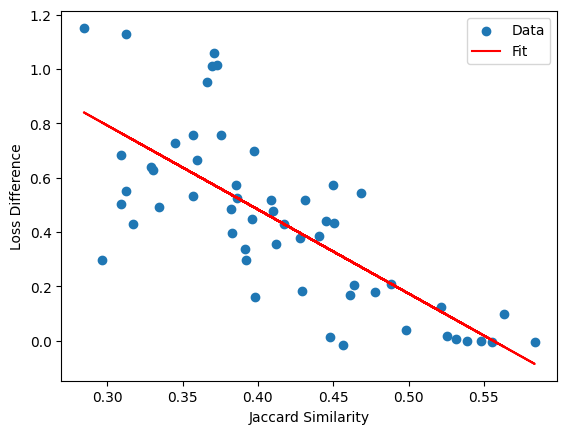

In [51]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
X = df[['jaccard_similarity']]
y = df['loss_diff']
model = LinearRegression()
model.fit(X, y)
print("Slope:", model.coef_[0])
print("Intercept:", model.intercept_)
print("R^2:", model.score(X, y))

plt.scatter(X, y, label='Data')
plt.plot(X, model.predict(X), color='red', label='Fit')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Loss Difference')
plt.legend()
plt.show()

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_vs_jaccard(jc_sims, accuracy_drops, x_bounds=None,
                             plot_title="Accuracy Drop vs Jaccard Similarity", save_fig_path=None):
    X = np.array(jc_sims).reshape(-1, 1)
    y = np.array(accuracy_drops)
    
    if x_bounds is not None:
        mask = (X[:, 0] >= x_bounds[0]) & (X[:, 0] <= x_bounds[1])
        X_filtered = X[mask]
        y_filtered = y[mask]
    else:
        X_filtered = X
        y_filtered = y

    model = LinearRegression()
    model.fit(X_filtered, y_filtered)
    y_pred_filtered = model.predict(X_filtered)
    r2 = r2_score(y_filtered, y_pred_filtered)
    r = np.corrcoef(X_filtered[:, 0], y_filtered)[0, 1]

    x_line = np.linspace(X_filtered.min(), X_filtered.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)

    plt.scatter(X, y)
    plt.plot(x_line, y_line, linestyle='--', linewidth=2, color='red',
             label=f"$R^2$={r2:.2f}, r={r:.2f}")

    plt.xlabel("Edge Jaccard Similarity", fontsize=11)
    plt.ylabel("Cross Entropy Loss Difference", fontsize=11)
    plt.title(plot_title, fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=10)
    plt.tight_layout()

    if save_fig_path:
        plt.savefig(save_fig_path, format='pdf', dpi=600)
    plt.show()

    return model, r2, r

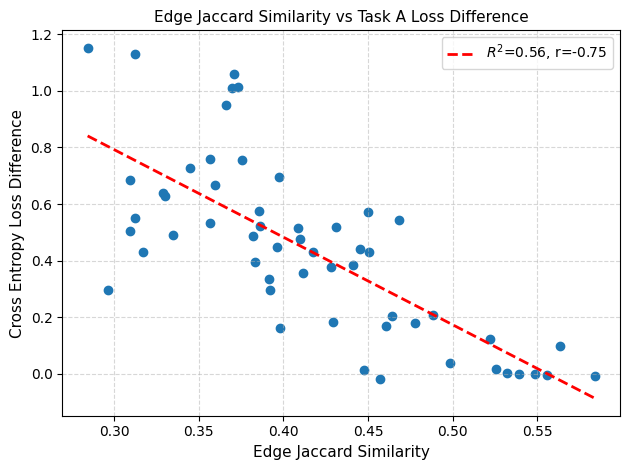

(LinearRegression(), 0.5556423070909324, -0.745414184927368)

In [62]:
plot_accuracy_vs_jaccard(
    X, y, 
    plot_title="Edge Jaccard Similarity vs Task A Loss Difference",
    save_fig_path='loss_diff_jc.png'
)